In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from ecgfuns import *
from tqdm import tqdm
# simple lambda-comprehension
remove_nans = lambda x: [i for i in x if not pd.isna(i)]

In [2]:
import sys
sys.path.append('./py-bwr/')
import bwr

# Sample 122
**the same as in `ecg-commented.ipynb`**

In [3]:
# read the data
a = pd.read_csv('./data/peaks_data_122.csv.gz')
a.head()

,Time_s,Laser_V,ECG_ch1,Las_peaks,ECG_peaks
0,0.0000,-0.00200,0.0,NaN,NaN
1,0.0001,-0.00200,0.0,NaN,NaN
2,0.0002,-0.00157,0.0,NaN,NaN
3,0.0003,-0.00157,0.0,NaN,NaN
4,0.0004,-0.00242,0.0,NaN,NaN


In [4]:
# subtract baseline
bl = bwr.calc_baseline( a.ECG_ch1.to_numpy() )
a['ch1_bc'] = 0.00
a.loc[:,'ch1_bc'] = a.ECG_ch1.to_numpy() - bl

a.head()

,Time_s,Laser_V,ECG_ch1,Las_peaks,ECG_peaks,ch1_bc
0,0.0000,-0.00200,0.0,NaN,NaN,0.009622
1,0.0001,-0.00200,0.0,NaN,NaN,0.009717
2,0.0002,-0.00157,0.0,NaN,NaN,0.009812
3,0.0003,-0.00157,0.0,NaN,NaN,0.009908
4,0.0004,-0.00242,0.0,NaN,NaN,0.010005


In [5]:
# add PCA-filtered data of original and baseline-corrected values
b = addFilteredDataE(a, 'ch1_bc', comps=3)
b = addFilteredDataE(b, 'ECG_ch1', comps=3)

Mean len of RR interval:  1999
Mean len of RR interval:  2292
Mean len of RR interval:  1999
Mean len of RR interval:  2292


In [14]:
# determine position of pacing start
pacingStart = b.query('Las_peaks == 1').index[0]
# -//- pacing end
pacingEnd = b.query('Las_peaks == 1').index[-1]

# small function for processing complex shape
def process_df(bc):
    bc['RRN'] = 0
    bc['relJ'] = np.nan
    bs = bc.astype({'relJ': 'float'})
    rrn = 0
    for j in tqdm(bc.query('ECG_peaks == 1').index):
        rrn += 1
        for i in range(-1000,1000):
            if j+i <= bc.index[-1] and j+i >= bc.index[0]:
                bc.loc[j+i, 'RRN'] = rrn
                bc.loc[j+i, 'relJ'] = i/1e4

bc = b[:pacingStart].copy()
process_df(bc)

mc = b[pacingStart:pacingEnd].copy()
process_df(mc)

ec = b[pacingEnd:].copy()
process_df(ec)

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:21<00:00,  1.65it/s]


In [15]:
bc.columns

Index(['Time_s', 'Laser_V', 'ECG_ch1', 'Las_peaks', 'ECG_peaks', 'ch1_bc',
       'ch1_bc_dns', 'ECG_ch1_dns', 'RRN', 'relJ'],
      dtype='object')

In [16]:
# reduce memory
bc.drop(columns=['Time_s',	'Laser_V', 	'ECG_ch1', 	'Las_peaks', 'ECG_peaks', 'ch1_bc', 'ECG_ch1_dns'], inplace=True)
mc.drop(columns=['Time_s',	'Laser_V', 	'ECG_ch1', 	'Las_peaks', 'ECG_peaks', 'ch1_bc', 'ECG_ch1_dns'], inplace=True)
ec.drop(columns=['Time_s',	'Laser_V', 	'ECG_ch1', 	'Las_peaks', 'ECG_peaks', 'ch1_bc', 'ECG_ch1_dns'], inplace=True)

## Plot averaged complex structures

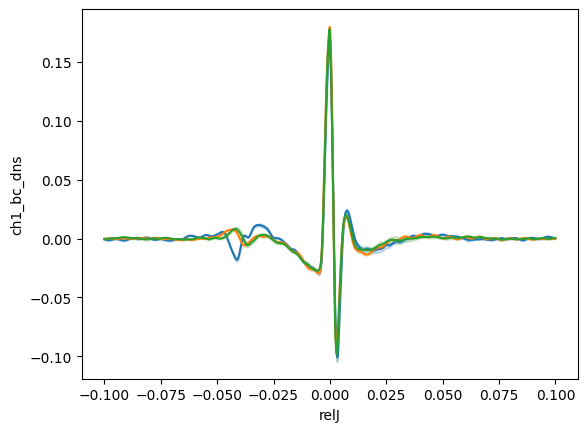

In [19]:
%matplotlib inline
# before pacing
sns.lineplot(data=bc.query('RRN > 0'), x='relJ', y='ch1_bc_dns')
# during pacing
sns.lineplot(data=mc.query('RRN > 0'), x='relJ', y='ch1_bc_dns')
# after pacing
sns.lineplot(data=ec.query('RRN > 0'), x='relJ', y='ch1_bc_dns')
plt.show()